In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.auto import tqdm
import pickle



%matplotlib inline
warnings.filterwarnings("ignore")

### Loading the dataset:

In [ ]:
ml_25m_path = "./ml-25M/ml-25m" #path to 25M dataset
ml_small_path = "./ml-latest-small" 

In [3]:
movies_df = pd.read_csv(f'{ml_25m_path}/movies.csv')

ratings_df = pd.read_csv(f'{ml_25m_path}/ratings.csv')


In [4]:
ratings_df = ratings_df.drop('timestamp', axis=1)

In [5]:
movies_df.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [6]:
ratings_df.head(2)

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5


### Data structure to Index data :
- by User
- by Movie

In [ ]:
# Get unique lists of movies and users
movies = ratings_df["movieId"].unique().tolist()
users = ratings_df["userId"].unique().tolist()

# Creating mappings 
idx_to_movieid = movies.copy()  
idx_to_userid = users.copy()    

# Creating reverse mappings 
movieid_to_idx = dict(enumerate(movies))  
userid_to_idx = dict(enumerate(users))    

# id->index mapping
movieid_to_idx = {v: k for k, v in movieid_to_idx.items()}
userid_to_idx = {v: k for k, v in userid_to_idx.items()}

In [ ]:
# Getting all data at once using DataFrame operations
user_movie_ratings = ratings_df[['userId', 'movieId', 'rating']].values

# Initializing lists with known sizes
n_users = ratings_df["userId"].nunique()
n_movies = ratings_df["movieId"].nunique()
user_data_list = [[] for _ in range(n_users)]
movie_data_list = [[] for _ in range(n_movies)]

for user_id, movie_id, rating in user_movie_ratings:
    user_idx = userid_to_idx[user_id]
    movie_idx = movieid_to_idx[movie_id]
    user_data_list[user_idx].append((movie_idx, rating))
    movie_data_list[movie_idx].append((user_idx, rating))

print(f"Length of user_data_list: {len(user_data_list)}")
print(f"Length of movie_data_list: {len(movie_data_list)}")

Length of user_data_list: 162541
Length of movie_data_list: 59047


In [9]:
user_data_list = [np.array(data) for data in user_data_list]
movie_data_list = [np.array(data) for data in movie_data_list]

#### Plot rating distributions of data

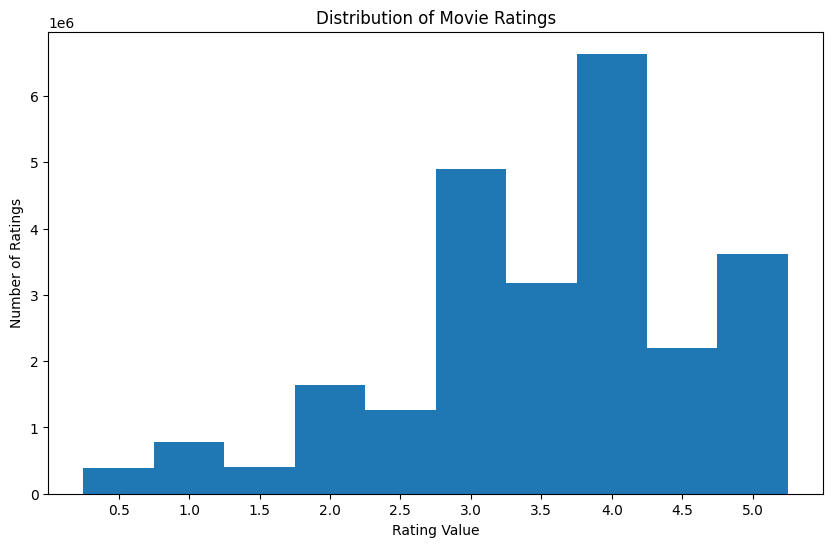

In [ ]:
# Calculating rating counts
rating_counts = ratings_df['rating'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, 
        height=rating_counts.values, 
        width=0.5, 
        align='center')

plt.xticks(rating_counts.index)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Number of Ratings')

# Saving the plot to dir
plt.savefig('./assets/25M-dataset/ratings_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

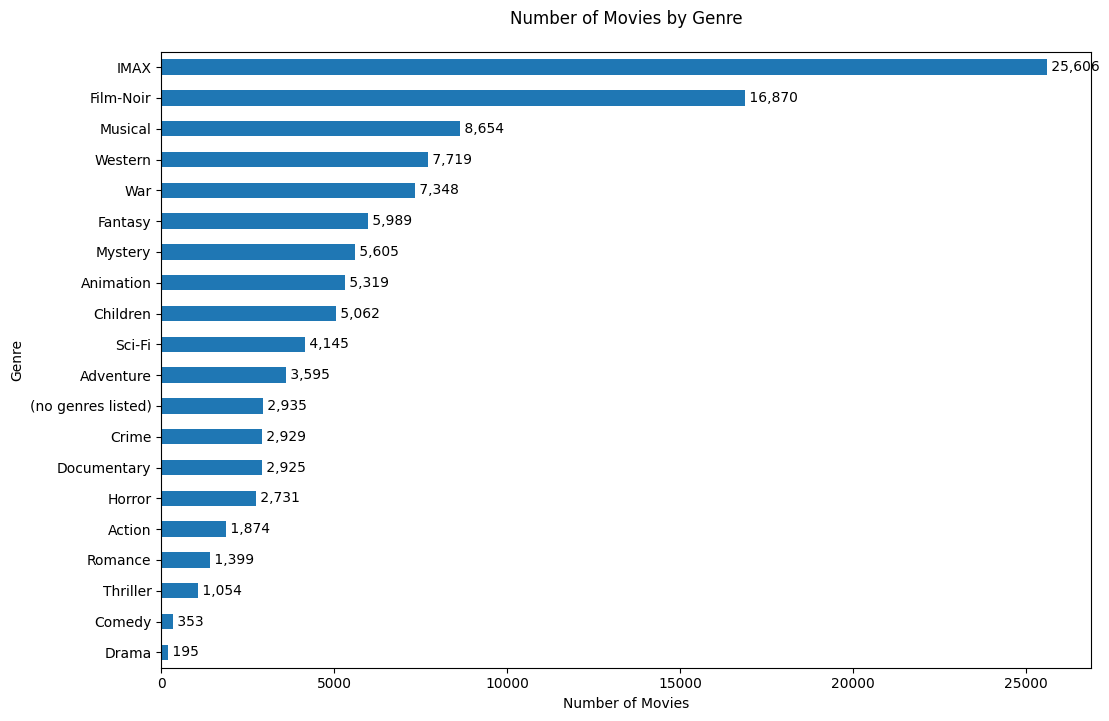

In [ ]:
# Getting genre counts
genre_counts = pd.Series('|'.join(movies_df['genres']).split('|')).value_counts()

plt.figure(figsize=(12, 8))

# Creating horizontal bar plot
ax = genre_counts[::-1].plot(kind='barh')

for i, v in enumerate(genre_counts[::-1]):
    ax.text(v, i, f' {v:,}', va='center')  

plt.title('Number of Movies by Genre', pad=20)
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

plt.yticks(range(len(genre_counts)), genre_counts.index)

# Saving the plot and close
plt.savefig('./assets/25M-dataset/Number_of_movies_by_genre.pdf', bbox_inches='tight')
plt.show()
plt.close()

#### Checking for Power laws

In [ ]:
def power_law(save_file_path):
   # Calculating ratings counts
   user_rating_counts = ratings_df.groupby('userId')['rating'].count()
   movie_rating_counts = ratings_df.sort_values(by=['movieId']).groupby('movieId')['rating'].count()

   # Getting distributions
   user_degrees = user_rating_counts.value_counts().sort_index()
   movie_degrees = movie_rating_counts.value_counts().sort_index()

   # subplot figure
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

   # User ratings plot
   ax1.scatter(user_degrees.index, user_degrees.values, color='blue', alpha=0.5)
   ax1.set_xscale('log')
   ax1.set_yscale('log')
   ax1.set_xlabel('Number of Ratings per User (log scale)')
   ax1.set_ylabel('Number of Users (log scale)') 
   ax1.set_title('Distribution of User Ratings')
   ax1.grid(True)

   # Movie ratings plot
   ax2.scatter(movie_degrees.index, movie_degrees.values, color='green', alpha=0.5)
   ax2.set_xscale('log')
   ax2.set_yscale('log')
   ax2.set_xlabel('Number of Ratings per Movie (log scale)')
   ax2.set_ylabel('Number of Movies (log scale)')
   ax2.set_title('Distribution of Movie Ratings')
   ax2.grid(True)

   plt.tight_layout()
   
   # Saving plots
   plt.savefig(save_file_path, bbox_inches='tight')

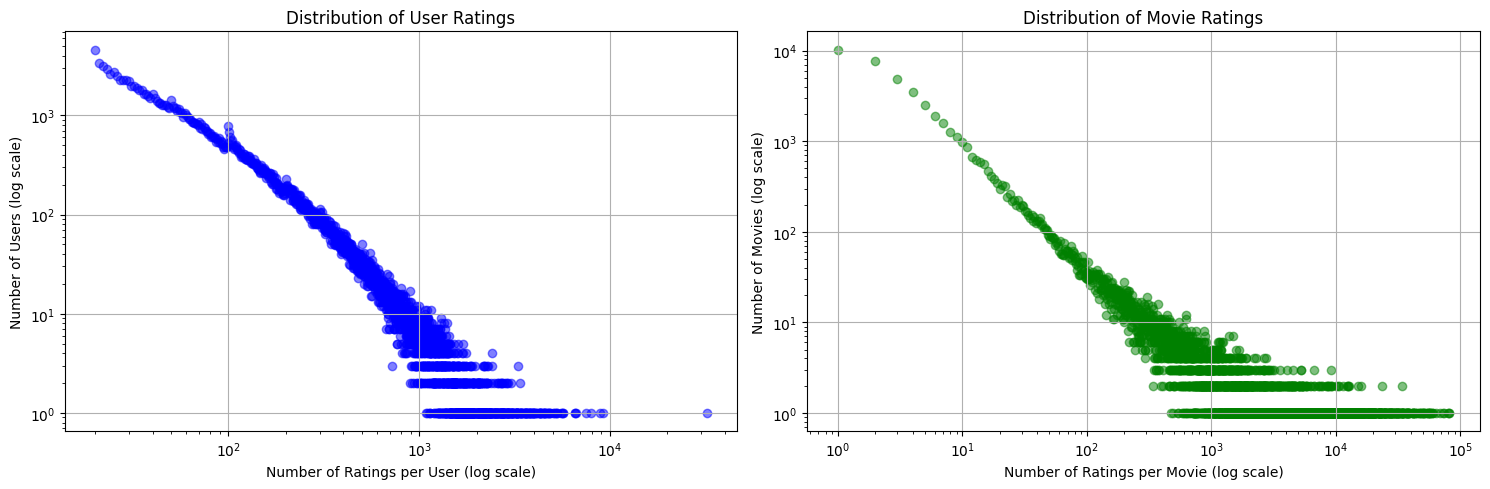

In [14]:
power_law('./assets/25M-dataset/powerlaw.pdf')

There are indeed power laws in the data

### A model with biases only

#### Splitting into train and test set:

In [15]:
key = np.random.default_rng(0)
user_ids = ratings_df['userId'].tolist()
movie_ids = ratings_df['movieId'].tolist()
ratings = ratings_df['rating'].tolist()
train_user_data_list = [[] for _ in range(ratings_df["userId"].nunique())]
test_user_data_list = [[] for _ in range(ratings_df["userId"].nunique())]
train_movie_data_list = [[] for _ in range(ratings_df["movieId"].nunique())]
test_movie_data_list = [[] for _ in range(ratings_df["movieId"].nunique())]

for user_id, movie_id, rating in zip(user_ids, movie_ids, ratings):
  if key.uniform(0, 1) < 0.8:
    train_user_data_list[userid_to_idx[user_id]].append((movieid_to_idx[movie_id], rating))
    train_movie_data_list[movieid_to_idx[movie_id]].append((userid_to_idx[user_id], rating))
  else:
    test_user_data_list[userid_to_idx[user_id]].append((movieid_to_idx[movie_id], rating))
    test_movie_data_list[movieid_to_idx[movie_id]].append((userid_to_idx[user_id], rating))


print("Length of train_user_data_list:", len(train_user_data_list))
print("Length of test_user_data_list:", len(test_user_data_list))
print("Length of train_user_data_list:", len(train_movie_data_list))
print("Length of test_user_data_list:", len(test_movie_data_list))

Length of train_user_data_list: 162541
Length of test_user_data_list: 162541
Length of train_user_data_list: 59047
Length of test_user_data_list: 59047


In [16]:
train_user_data_list = [np.array(data) for data in train_user_data_list]
test_user_data_list = [np.array(data) for data in test_user_data_list]
train_movie_data_list = [np.array(data) for data in train_movie_data_list]
test_movie_data_list = [np.array(data) for data in test_movie_data_list]

In [ ]:
# Constants
M = len(user_data_list)
N = len(movie_data_list)
k = 10
iterations = 100
lambda_ = 1
gamma = 0.0001

# Initialize biases and tracking metrics
user_biases = np.zeros(M)
item_biases = np.zeros(N)
train_losses = []
train_errors = []
test_losses = []
test_errors = []

# Training Loop
for i in range(iterations):
    # Update user biases
    for m, user_data in enumerate(train_user_data_list):
        if user_data.size > 0:  # Check if user has data
            ratings = user_data[:, 1]
            indices = user_data[:, 0].astype(int)
            user_biases[m] = lambda_ * np.sum(ratings - item_biases[indices]) / (lambda_ * len(indices) + gamma)

    # Update item biases
    for q, movie_data in enumerate(train_movie_data_list):
        if movie_data.size > 0:  # Check if movie has data
            ratings = movie_data[:, 1]
            indices = movie_data[:, 0].astype(int)
            item_biases[q] = lambda_ * np.sum(ratings - user_biases[indices]) / (lambda_ * len(indices) + gamma)


    # Compute training loss and RMSE and test RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m, train_user_data in enumerate(train_user_data_list):
        if train_user_data.size > 0:  # Check if user has data
            ratings = train_user_data[:, 1]
            indices = train_user_data[:, 0].astype(int)
            residuals = ratings - user_biases[m] - item_biases[indices]
            train_error_squared += np.sum(residuals**2)
            train_size += len(ratings)

    for j, test_user_data in enumerate(test_user_data_list):
        if test_user_data.size > 0:  # Check if user has data
            ratings = test_user_data[:, 1]
            indices = test_user_data[:, 0].astype(int)
            residuals = ratings - user_biases[j] - item_biases[indices]
            test_error_squared += np.sum(residuals**2)
            test_size += len(ratings)

    train_loss = -0.5 * lambda_ * train_error_squared - 0.5 * gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))
    train_error = np.sqrt(train_error_squared / train_size)

    # Track train metrics
    train_losses.append(-train_loss)
    train_errors.append(train_error)

    test_loss = -0.5 * lambda_ * test_error_squared - 0.5 * gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))
    test_error = np.sqrt(test_error_squared / test_size)

    # Track test metrics
    test_losses.append(-test_loss)
    test_errors.append(test_error)

    print(f"Train Loss: {-train_loss:.2f} | Test Loss: {-test_loss:.2f} | Train RMSE: {train_error:.4f} | Test RMSE: {test_error:.4f}")



Train Loss: 7490334.47 | Test Loss: 1916648.14 | Train RMSE: 0.8654 | Test RMSE: 0.8758
Train Loss: 7227339.02 | Test Loss: 1850437.30 | Train RMSE: 0.8501 | Test RMSE: 0.8605
Train Loss: 7214743.24 | Test Loss: 1847385.15 | Train RMSE: 0.8493 | Test RMSE: 0.8598
Train Loss: 7213894.12 | Test Loss: 1847197.49 | Train RMSE: 0.8493 | Test RMSE: 0.8598
Train Loss: 7213801.45 | Test Loss: 1847176.86 | Train RMSE: 0.8493 | Test RMSE: 0.8597
Train Loss: 7213786.05 | Test Loss: 1847171.83 | Train RMSE: 0.8493 | Test RMSE: 0.8597
Train Loss: 7213782.93 | Test Loss: 1847169.92 | Train RMSE: 0.8493 | Test RMSE: 0.8597
Train Loss: 7213782.26 | Test Loss: 1847169.07 | Train RMSE: 0.8493 | Test RMSE: 0.8597
Train Loss: 7213782.11 | Test Loss: 1847168.68 | Train RMSE: 0.8493 | Test RMSE: 0.8597
Train Loss: 7213782.08 | Test Loss: 1847168.49 | Train RMSE: 0.8493 | Test RMSE: 0.8597
Train Loss: 7213782.07 | Test Loss: 1847168.40 | Train RMSE: 0.8493 | Test RMSE: 0.8597
Train Loss: 7213782.07 | Test Lo

In [18]:
def plot_and_save_loss(array_to_plot, filename, ylabel):
    
    plt.figure(figsize=(8, 6))
    plt.plot(array_to_plot, color='blue', linewidth=2)
    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()


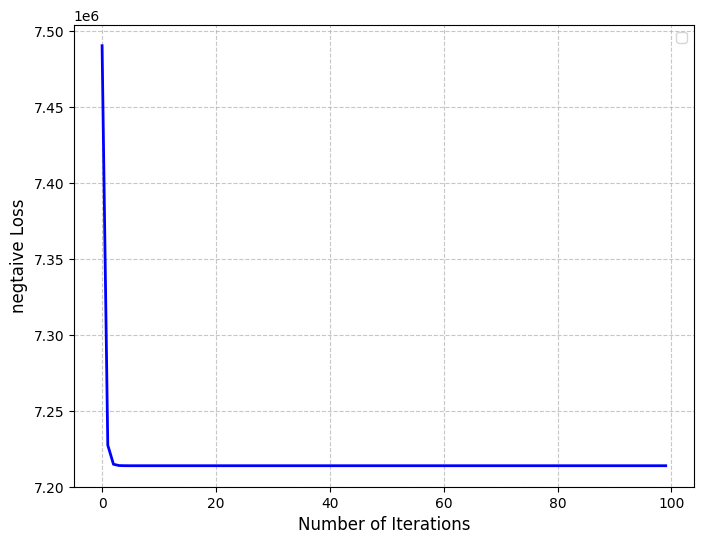

In [19]:
plot_and_save_loss(train_losses, './assets/25M-dataset/train_neg_loss.pdf', 'negtaive Loss')

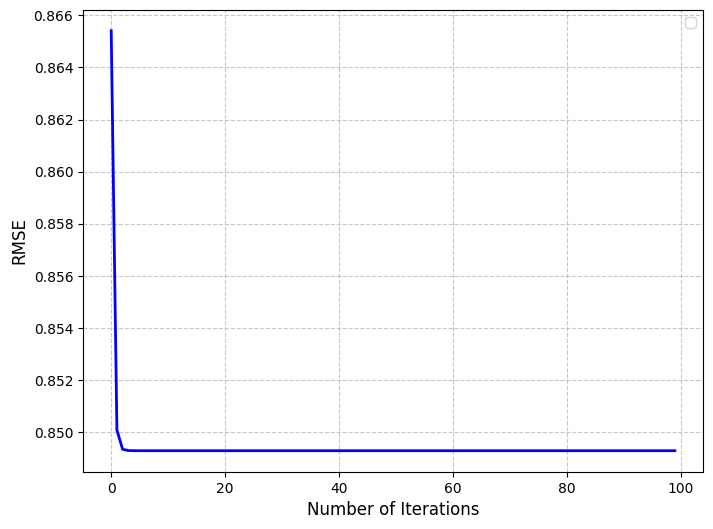

In [20]:
plot_and_save_loss(train_errors, './assets/25M-dataset/train_neg_rmse.pdf', 'RMSE')

The training error converges to  0.8493

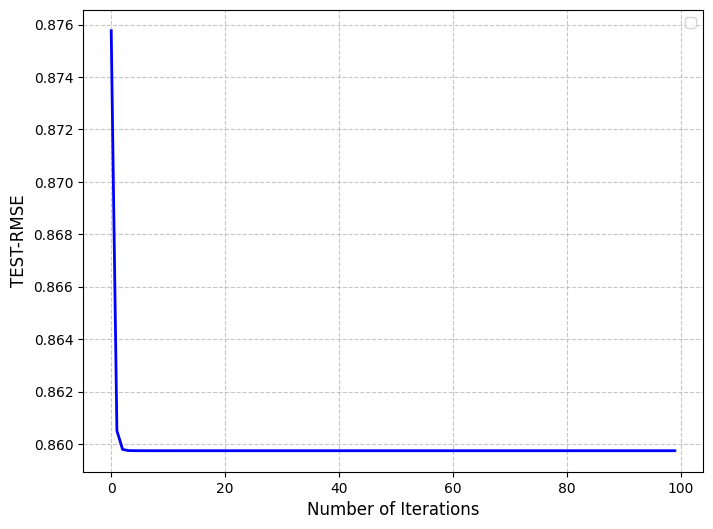

In [21]:
plot_and_save_loss(test_errors, './assets/25M-dataset/test_neg_rmse.pdf', 'TEST-RMSE')

The test error converges to 0.8597

# Practical 3

### A model with embeddings

#### For K = 10

In [ ]:
M = len(train_user_data_list)
N = len(train_movie_data_list)
k=10
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
train_losses_k_10=[]
test_losses_k_10=[]
train_errors_k_10=[]
test_errors_k_10=[]
iter = 100
lambda_ = 1
gamma = 0.001
tau = 1

In [ ]:
for i in range(iter):
    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_data_list) > 0:
            ratings = train_user_data_list[m][:, 1]
            indices = train_user_data_list[m][:, 0].astype(int)

            # Calculate user bias
            user_bias = lambda_ * np.sum(ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - item_biases[indices]) / (lambda_ * len(indices) + gamma)
            user_biases[m] = user_bias

            left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

            # Update user factor
            user_latent_vectors[m] = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_data_list[n]) > 0:
            ratings = train_movie_data_list[n][:, 1]
            indices = train_movie_data_list[n][:, 0].astype(int)

            # Calculate item bias
            item_bias = lambda_ * np.sum(ratings - np.einsum('ij,j->i', user_latent_vectors[indices], item_latent_vectors[n]) - user_biases[indices]) / (lambda_ * len(indices) + gamma)
            item_biases[n] = item_bias

            left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

            # Update item factor
            item_latent_vectors[n] = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    # Calculate training and testing loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m in range(M):
        if len(train_user_data_list[m]) > 0:
            train_ratings = train_user_data_list[m][:, 1]
            train_indices = train_user_data_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)

        if len(test_user_data_list[m]) > 0:
            test_ratings = test_user_data_list[m][:, 1]
            test_indices = test_user_data_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)

    train_loss = -0.5 * lambda_ * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    train_error = np.sqrt(1 / train_size * train_error_squared)

    train_losses_k_10.append(-train_loss)
    train_errors_k_10.append(train_error)

    test_loss = -0.5 * lambda_ * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij, ij->', user_latent_vectors, user_latent_vectors))
    test_error = np.sqrt(1/test_size * test_error_squared)

    test_losses_k_10.append(-test_loss)
    test_errors_k_10.append(test_error)

    print(f"Train Loss: {-train_loss:.2f} | Test Loss: {-test_loss:.2f} | Train RMSE: {train_error:.4f} | Test RMSE: {test_error:.4f}")


Train Loss: 6918350.06 | Test Loss: 2168880.99 | Train RMSE: 0.8245 | Test RMSE: 0.9055
Train Loss: 6074763.27 | Test Loss: 1990602.97 | Train RMSE: 0.7711 | Test RMSE: 0.8633
Train Loss: 5635296.01 | Test Loss: 1876029.83 | Train RMSE: 0.7418 | Test RMSE: 0.8356
Train Loss: 5420580.48 | Test Loss: 1817973.75 | Train RMSE: 0.7272 | Test RMSE: 0.8214
Train Loss: 5305664.83 | Test Loss: 1785396.44 | Train RMSE: 0.7193 | Test RMSE: 0.8135
Train Loss: 5235037.89 | Test Loss: 1764517.30 | Train RMSE: 0.7144 | Test RMSE: 0.8087
Train Loss: 5187142.64 | Test Loss: 1749897.95 | Train RMSE: 0.7112 | Test RMSE: 0.8054
Train Loss: 5152798.04 | Test Loss: 1739011.89 | Train RMSE: 0.7088 | Test RMSE: 0.8030
Train Loss: 5127062.04 | Test Loss: 1730540.51 | Train RMSE: 0.7071 | Test RMSE: 0.8012
Train Loss: 5107014.81 | Test Loss: 1723764.20 | Train RMSE: 0.7058 | Test RMSE: 0.7998
Train Loss: 5090912.36 | Test Loss: 1718260.36 | Train RMSE: 0.7047 | Test RMSE: 0.7987
Train Loss: 5077695.86 | Test Lo

#### For K = 20

In [ ]:
M = len(train_user_data_list)
N = len(train_movie_data_list)
k=20
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
train_losses_k_20=[]
test_losses_k_20=[]
train_errors_k_20=[]
test_errors_k_20=[]
iter = 100
lambda_ = 1
gamma = 0.001
tau = 1


In [ ]:
for i in range(iter):
    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_data_list) > 0:
            ratings = train_user_data_list[m][:, 1]
            indices = train_user_data_list[m][:, 0].astype(int)

            # Calculate user bias
            user_bias = lambda_ * np.sum(ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - item_biases[indices]) / (lambda_ * len(indices) + gamma)
            user_biases[m] = user_bias

            left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

            # Update user factor
            user_latent_vectors[m] = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_data_list[n]) > 0:
            ratings = train_movie_data_list[n][:, 1]
            indices = train_movie_data_list[n][:, 0].astype(int)

            # Calculate item bias
            item_bias = lambda_ * np.sum(ratings - np.einsum('ij,j->i', user_latent_vectors[indices], item_latent_vectors[n]) - user_biases[indices]) / (lambda_ * len(indices) + gamma)
            item_biases[n] = item_bias

            # Calculate left and right matrices for item factor update
            left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

            # Update item factor
            item_latent_vectors[n] = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    # Calculate training loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m in range(M):
        if len(train_user_data_list[m]) > 0:
            train_ratings = train_user_data_list[m][:, 1]
            train_indices = train_user_data_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)

        if len(test_user_data_list[m]) > 0:
            test_ratings = test_user_data_list[m][:, 1]
            test_indices = test_user_data_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)

    train_loss = -0.5 * lambda_ * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    train_error = np.sqrt(1 / train_size * train_error_squared)

    train_losses_k_20.append(-train_loss)
    train_errors_k_20.append(train_error)

    test_loss = -0.5 * lambda_ * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij, ij->', user_latent_vectors, user_latent_vectors))
    test_error = np.sqrt(1/test_size * test_error_squared)

    test_losses_k_20.append(-test_loss)
    test_errors_k_20.append(test_error)

    print(f"Train Loss: {-train_loss:.2f} | Test Loss: {-test_loss:.2f} | Train RMSE: {train_error:.4f} | Test RMSE: {test_error:.4f}")


Train Loss: 6480870.69 | Test Loss: 2402804.76 | Train RMSE: 0.7888 | Test RMSE: 0.9265
Train Loss: 5473063.64 | Test Loss: 2185344.50 | Train RMSE: 0.7228 | Test RMSE: 0.8805
Train Loss: 5020794.78 | Test Loss: 2058598.85 | Train RMSE: 0.6914 | Test RMSE: 0.8532
Train Loss: 4779945.71 | Test Loss: 1985819.38 | Train RMSE: 0.6744 | Test RMSE: 0.8379
Train Loss: 4641311.39 | Test Loss: 1943425.94 | Train RMSE: 0.6645 | Test RMSE: 0.8293
Train Loss: 4554656.85 | Test Loss: 1917191.13 | Train RMSE: 0.6584 | Test RMSE: 0.8244
Train Loss: 4496211.73 | Test Loss: 1899924.75 | Train RMSE: 0.6544 | Test RMSE: 0.8215
Train Loss: 4454326.80 | Test Loss: 1887997.09 | Train RMSE: 0.6515 | Test RMSE: 0.8197
Train Loss: 4422879.33 | Test Loss: 1879453.24 | Train RMSE: 0.6494 | Test RMSE: 0.8186
Train Loss: 4398382.65 | Test Loss: 1873147.54 | Train RMSE: 0.6478 | Test RMSE: 0.8180
Train Loss: 4378727.04 | Test Loss: 1868353.91 | Train RMSE: 0.6465 | Test RMSE: 0.8176
Train Loss: 4362572.89 | Test Lo

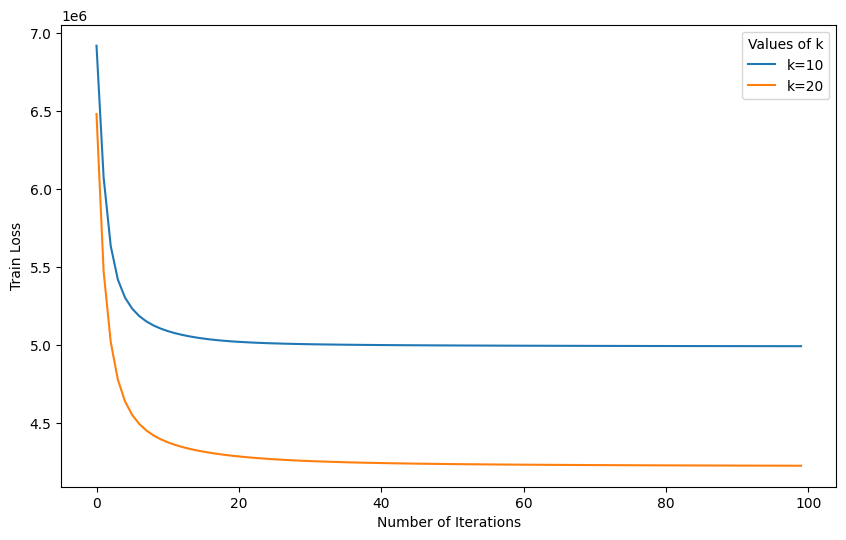

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting losses
loss_data = {"k=10": train_losses_k_10, "k=20": train_losses_k_20}
for label, losses in loss_data.items():
    plt.plot(losses, label=label)

plt.xlabel('Number of Iterations')
plt.ylabel('Train Loss')
plt.legend(title="Values of k")

# Save plot to file
plt.savefig('./assets/25M-dataset/train_losses_k_10_20.pdf', bbox_inches='tight');


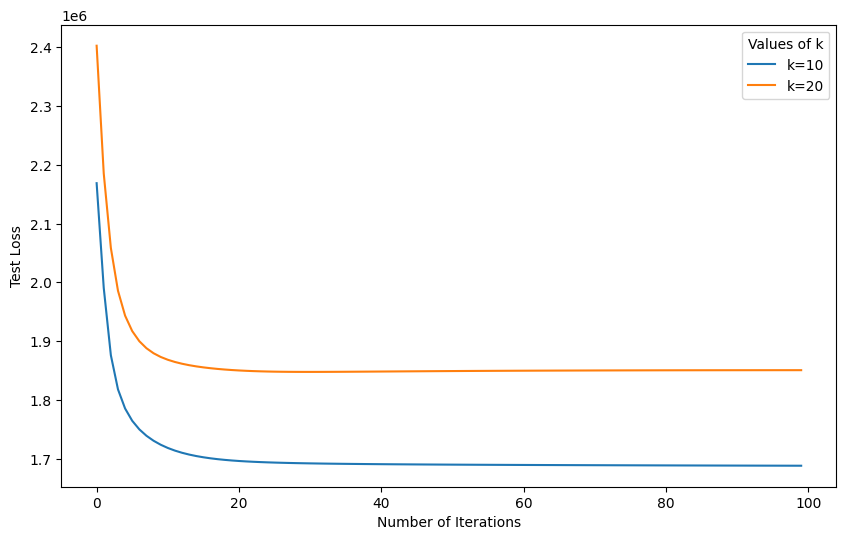

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting losses
loss_data = {"k=10": test_losses_k_10, "k=20": test_losses_k_20}
for label, losses in loss_data.items():
    plt.plot(losses, label=label)

plt.xlabel('Number of Iterations')
plt.ylabel('Test Loss')
plt.legend(title="Values of k")

# Save plot to file
plt.savefig('./assets/25M-dataset/test_losses_k_10_20.pdf', bbox_inches='tight');


#### Show that if a user liked movie X (your choice) the recommendations Y make sense

In [34]:
# To avoid rerunning items+latent vector codes, I saved the k=20 results as pickle:

import pickle

data_to_save = {
    './models/user_b_k_20.pkl': user_biases,
    './models/item_b_k_20.pkl': item_biases,
    './models/user_latent_vec_k_20.pkl': user_latent_vectors,
    './models/item_latent_vec_k_20.pkl': item_latent_vectors
}

for filename, data in data_to_save.items():
    with open(filename, 'wb') as f:
        pickle.dump(data, f)


In [ ]:
# creating dummy user:

def dummy_user(dummy_movie_and_rating, k=10, num_iter=100, lambda_=0.01, gamma=0.001, tau=0.001):
    
    dummy_latent_vectors = np.zeros(k)
    dummy_movie_and_rating = np.array(dummy_movie_and_rating)

    if dummy_movie_and_rating.ndim == 1:
        dummy_movie_and_rating = dummy_movie_and_rating.reshape(1, -1)
    
    # Extract ratings and indices from user data
    ratings = dummy_movie_and_rating[:, 1]
    indices = dummy_movie_and_rating[:, 0].astype(int)

    for _ in range(num_iter):
        # Compute user bias
        user_bias = (
            lambda_ * np.sum(
                ratings - np.einsum('i,ji->j', dummy_latent_vectors, item_latent_vectors[indices]) - item_biases[indices]
            ) / (lambda_ * len(indices) + gamma)
        )

        left = np.einsum('ij,ik->jk', item_latent_vectors[indices], item_latent_vectors[indices])
        right = np.sum(
            np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]),
            axis=0
        )
        
        # Update the dummy user latent factors
        dummy_latent_vectors = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    return dummy_latent_vectors


Here I used `Lord of the Rings` for getting prediction for the dummy user :

In [36]:
# Adding a new column mapping movie IDs to indices in the original movies_df
movies_df['movie_index'] = movies_df['movieId'].map(movieid_to_idx)

key_words = "Lord of the Rings"
filtered_movies = movies_df[movies_df['title'].str.contains(key_words, case=False, na=False)]

print(filtered_movies[['title', 'movie_index']])


                                                  title  movie_index
2026                      Lord of the Rings, The (1978)       2189.0
4887  Lord of the Rings: The Fellowship of the Ring,...        202.0
5840      Lord of the Rings: The Two Towers, The (2002)         36.0
7028  Lord of the Rings: The Return of the King, The...        227.0


In [ ]:
def dummy_user(dummy_movie_and_rating, k=20, num_iter=100, lambda_=0.01, gamma=0.001, tau=0.001):
    
    user_latent_vectors = np.zeros(k)
    dummy_movie_and_rating = np.array(dummy_movie_and_rating)

    if dummy_movie_and_rating.ndim == 1:
        dummy_movie_and_rating = dummy_movie_and_rating.reshape(1, -1)
    
    # Extract ratings and indices from user data
    ratings = dummy_movie_and_rating[:, 1]
    indices = dummy_movie_and_rating[:, 0].astype(int)

    for _ in range(num_iter):
        # Compute user bias
        predictions = np.sum(user_latent_vectors[None, :] * item_latent_vectors[indices], axis=1)
        user_bias = (
            lambda_ * np.sum(ratings - predictions - item_biases[indices]) /
            (lambda_ * len(indices) + gamma)
        )

        left = np.einsum('ij,ik->jk', item_latent_vectors[indices], item_latent_vectors[indices])
        right = np.sum(
            item_latent_vectors[indices] * (ratings - user_bias - item_biases[indices])[:, None],
            axis=0
        )
        
        # Update the dummy user latent factors
        user_latent_vectors = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    return user_latent_vectors

In [54]:
dummy_latent_vectors = dummy_user([202, 5])

In [55]:
# Getting top predictions for this dummy user
predicted_scores = np.einsum('i,ji->j', dummy_latent_vectors, item_latent_vectors) + 0.01 * item_biases

# Sorting movie indices by scores in descending order
ranked_movie_indices = np.argsort(predicted_scores)[::-1]

# Filtering and collecting top 5 predictions
recommended_movies = [
    movies_df.loc[movies_df['movie_index'] == index, 'title'].iloc[0]
    for index in ranked_movie_indices
    if len(movie_data_list[index]) >= 350
][:5]

In [56]:
recommended_movies

['Lord of the Rings: The Return of the King, The (2003)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Hobbit: The Desolation of Smaug, The (2013)',
 'Hobbit: An Unexpected Journey, The (2012)']

> As seen above, the top recommendations are Other lord of the rings movies as well as the Hobbit which is closely related to the 'Lord of the Rings Movie'

#### Can you find and show which movies as polarizing?

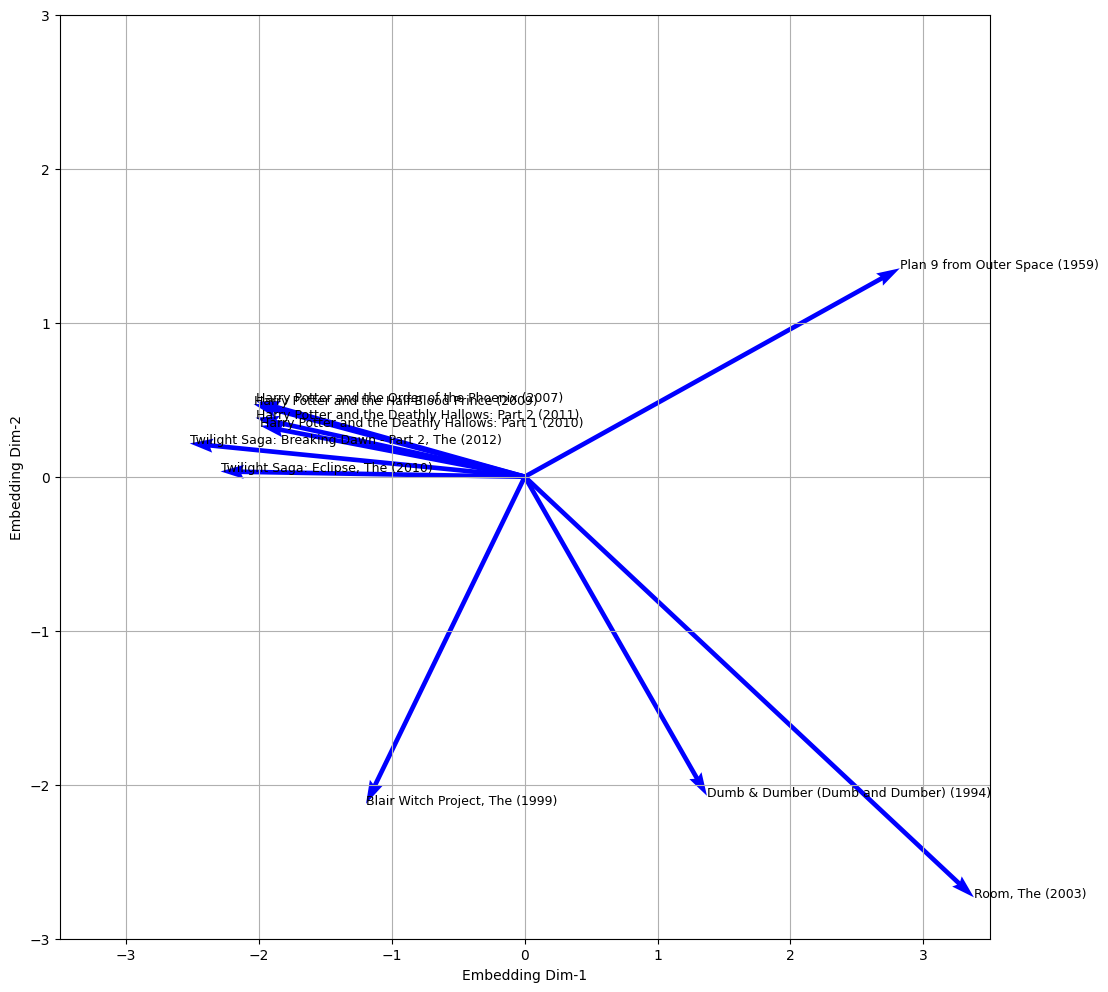

In [ ]:
# visualizing Polarizing movies:
plt.figure(figsize=(12, 12))

# Euclidean distances from the origin
distances = np.linalg.norm(item_latent_vectors, axis=1)

top_10_idxs = np.argsort(distances)[-10:]


# trait vectors of the top 10 polarizing movies
plt.quiver(
    np.zeros(len(top_10_idxs)), np.zeros(len(top_10_idxs)),
    item_latent_vectors[top_10_idxs, 0], item_latent_vectors[top_10_idxs, 1],
    angles='xy', scale_units='xy', scale=1, color='b', width=0.005, label='Most Polarizing'
)

for idx in top_10_idxs:
    movie_title = movies_df.loc[movies_df['movie_index'] == idx, 'title'].values[0]
    plt.text(
        item_latent_vectors[idx, 0], item_latent_vectors[idx, 1],
        movie_title, fontsize=9, color='k'
    )

plt.xlim(-3.5, 3.5)
plt.ylim(-3, 3)
plt.xlabel('Embedding Dim-1')
plt.ylabel('Embedding Dim-2')
plt.grid(True)

plt.savefig('./assets/25M-dataset/polarizing_movies.pdf', bbox_inches='tight');
